---

**Matteo Serafino**   
**Date:** June 26, 2025  
**Email:** [matteo.serafino191@gmail.com](mailto:matteo.serafino191@gmail.com)

---
This notebook contains the analysis for: "Cognitive distortions are associated with increasing political polarization" by Andy Edinger, Johan Bollena, Hernán A. Makse, and Matteo Serafino.
---


In [1]:
import pandas as pd
import json
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

import scipy.stats as stats
from scipy.stats import ttest_ind,ttest_rel
from scipy.signal import find_peaks

from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api as sm


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Import necessary libraries
import pandas as pd

# Load the user distortion data
users_distortion = pd.read_csv('user_cds.csv')
# Ensure that the 'user_id' column is of string type
users_distortion['user_id'] = users_distortion['user_id'].astype(str)

# Load the 2016 ideology estimates
users_ideology_2016 = pd.read_csv('ideology_estimates_2016_paper.csv')
# Ensure that the 'account_id' column is of string type
users_ideology_2016['account_id'] = users_ideology_2016['account_id'].astype(str)

# Load the 2020 ideology estimates
users_ideology_2020 = pd.read_csv('ideology_estimates_2020_paper.csv')
# Ensure that the 'account_id' column is of string type
users_ideology_2020['account_id'] = users_ideology_2020['account_id'].astype(str)

# Identify overlapping user IDs across all three datasets
users_overlaps = (set(users_ideology_2016['account_id'].to_list()) & 
                  set(users_ideology_2020['account_id'].to_list()) & 
                  set(users_distortion['user_id']))

# Print the number of overlapping users
print(f"Number of overlapping users: {len(users_overlaps)}")

# Filter the DataFrames to include only the overlapping users
users_ideology_2016_o = users_ideology_2016[users_ideology_2016.account_id.isin(users_overlaps)]
users_ideology_2020_o = users_ideology_2020[users_ideology_2020.account_id.isin(users_overlaps)]
users_distortion_o = users_distortion[users_distortion.user_id.isin(users_overlaps)].copy()

# Rename 'user_id' to 'account_id' in users_distortion_o to match the other DataFrames
users_distortion_o.rename(columns={'user_id': 'account_id'}, inplace=True)

# Merge filtered 2016 ideology estimates with the filtered distortion data
temp_2016 = pd.merge(users_ideology_2016_o, users_distortion_o, on='account_id', how='inner')

# Merge filtered 2020 ideology estimates with the filtered distortion data
temp_2020 = pd.merge(users_ideology_2020_o, users_distortion_o, on='account_id', how='inner')

# Select relevant columns from the temp_2020 DataFrame
temp_2020 = temp_2020[['account_id', 'est', '2016_prevalence', '2020_prevalence']]

# Merge temp_2020 with the filtered 2016 ideology estimates on 'account_id'
merged_df = temp_2020.merge(users_ideology_2016_o[['account_id', 'est']], on='account_id', how='left')

# Rename columns for clarity: 'est_x' to 'est_2020' and 'est_y' to 'est_2016'
merged_df.rename(columns={'est_x': 'est_2020', 'est_y': 'est_2016'}, inplace=True)

Number of overlapping users: 53493


# Section: CDS prevalence by year.

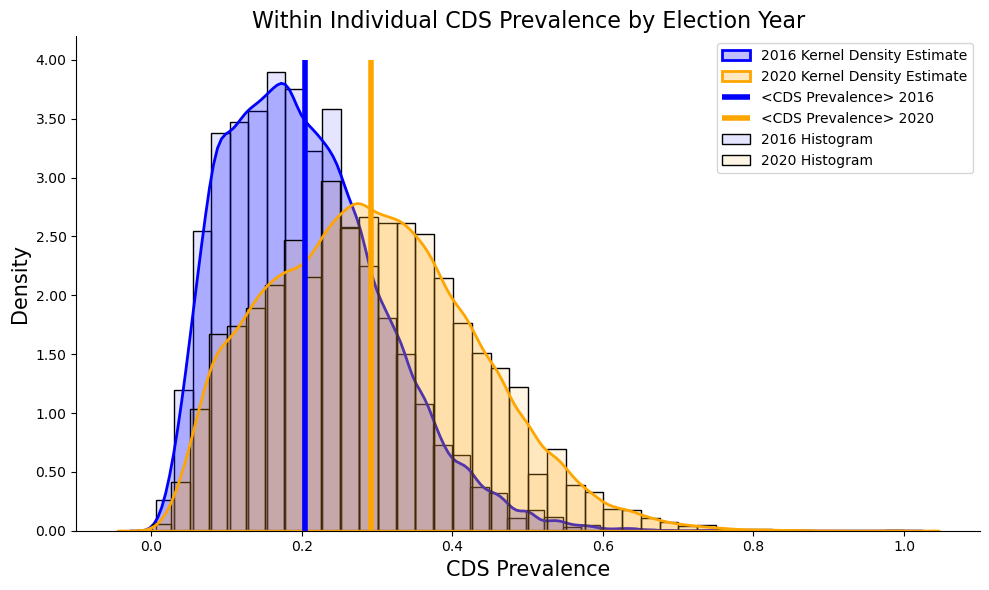

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

# Calculate the mean prevalence for 2016 and 2020
mean_2016 = temp_2016['2016_prevalence'].mean()
mean_2020 = temp_2020['2020_prevalence'].mean()

# Set up the figure size for the plot
plt.figure(figsize=(10, 6))

# Plot the normalized histogram for 2016 prevalence
sns.histplot(temp_2020['2016_prevalence'], bins=40, kde=False, stat='density', color='blue', alpha=0.1, label='2016 Histogram')

# Plot the KDE for 2016 prevalence
sns.kdeplot(data=temp_2020['2016_prevalence'], color='blue', fill=True, linewidth=2, label='2016 Kernel Density Estimate')

# Plot the normalized histogram for 2020 prevalence
sns.histplot(temp_2020['2020_prevalence'], bins=40, kde=False, stat='density', color='orange', alpha=0.1, label='2020 Histogram')

# Plot the KDE for 2020 prevalence
sns.kdeplot(data=temp_2020['2020_prevalence'], color='orange', fill=True, linewidth=2, label='2020 Kernel Density Estimate')

# Add vertical lines at the mean values for 2016 and 2020
plt.vlines(x=mean_2016, ymin=0, ymax=4, color='blue', linestyle='-', linewidth=4, label=f'<CDS Prevalence> 2016')
plt.vlines(x=mean_2020, ymin=0, ymax=4, color='orange', linestyle='-',linewidth=4,  label=f'<CDS Prevalence> 2020')

# Labeling the axes and the plot
plt.ylabel('Density', fontsize=15)
plt.xlabel('CDS Prevalence', fontsize=15)
plt.title('Within Individual CDS Prevalence by Election Year', fontsize=16)

# Hide the right and top spines of the plot
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Force y-axis to show numbers with 2 decimal places
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Adjust layout to prevent cutoff of labels
plt.tight_layout()
# Show the legend and the plot
plt.legend()

# Save the figure as a PDF file
plt.savefig('plots/Figure1.pdf')


plt.show()

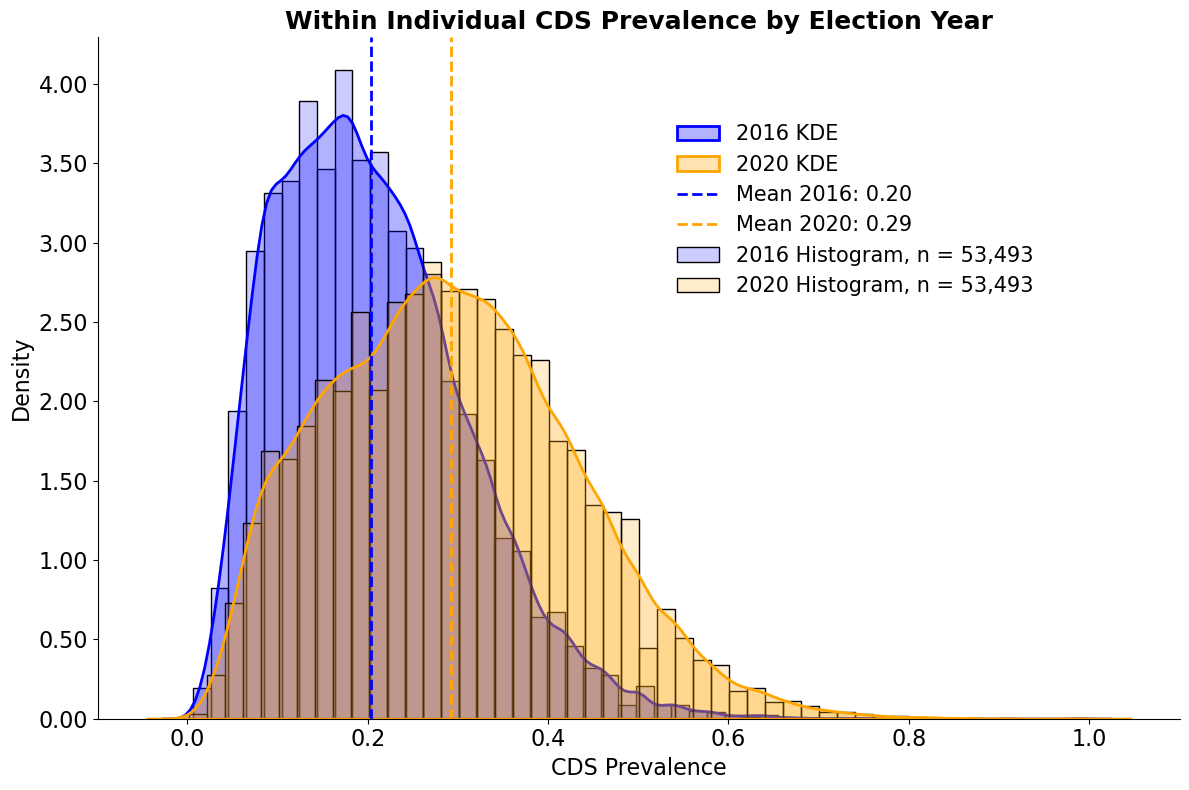

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

# Calculate means
mean_2016 = temp_2016['2016_prevalence'].mean()
mean_2020 = temp_2020['2020_prevalence'].mean()

# Initialize figure
plt.figure(figsize=(12, 8))

# Histogram + KDE for 2016
sns.histplot(temp_2020['2016_prevalence'], bins=50, stat='density',
             color='blue', alpha=0.2, edgecolor='black', label='2016 Histogram, n = 53,493')
sns.kdeplot(temp_2020['2016_prevalence'], color='blue', linewidth=2,
            fill=True, alpha=0.3, label='2016 KDE')

# Histogram + KDE for 2020
sns.histplot(temp_2020['2020_prevalence'], bins=50, stat='density',
             color='orange', alpha=0.2, edgecolor='black', label='2020 Histogram, n = 53,493')
sns.kdeplot(temp_2020['2020_prevalence'], color='orange', linewidth=2,
            fill=True, alpha=0.3, label='2020 KDE')

# Mean lines
plt.axvline(mean_2016, color='blue', linestyle='--', linewidth=2, label=f'Mean 2016: {mean_2016:.2f}')
plt.axvline(mean_2020, color='orange', linestyle='--', linewidth=2, label=f'Mean 2020: {mean_2020:.2f}')

# Title and axis labels
plt.title('Within Individual CDS Prevalence by Election Year', fontsize=18, weight='bold')
plt.xlabel('CDS Prevalence', fontsize=16)
plt.ylabel('Density', fontsize=16)

# Improve tick size
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Format y-axis
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Remove top/right spines
sns.despine()

# Larger, top-centered legend
plt.legend(loc='upper center', bbox_to_anchor=(0.7, 0.9),
           ncol=1, fontsize=15, title_fontsize=14, frameon=False)

# Prevent clipping
plt.tight_layout()

# Save and show
plt.savefig('plots/Figure1_readable.pdf')
plt.show()


In [5]:
print('The % increase in CDS prevalence from 2016 to 2020 is:', round((mean_2020-mean_2016)/mean_2016,2),'%')

The % increase in CDS prevalence from 2016 to 2020 is: 0.43 %


In [6]:
# Performing the paired sample t-test
ttest = stats.ttest_rel(temp_2020['2020_prevalence'],
                        temp_2020['2016_prevalence'], alternative='greater')

# Extract t-statistic and p-value
t_stat = ttest.statistic
p_value = ttest.pvalue

# Print results with more decimals for p-value
print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value:.100f}")  # Print the p-value with up to 100 decimal places


t-statistic: 153.8962992814723
p-value: 0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000


In [7]:
temp_2020

,account_id,est,2016_prevalence,2020_prevalence
0,100005598,-0.792264,0.217391,0.163522
1,10001212,-0.817307,0.290323,0.380952
2,100022411,1.330908,0.277778,0.243243
3,100024370,-0.632696,0.100000,0.157895
4,1000305042,1.286809,0.350000,0.500000
...,...,...,...,...
53488,9300262,-0.798322,0.095899,0.156374
53489,93069110,-0.810301,0.117423,0.174101
53490,950531,-0.813986,0.161447,0.220141
53491,95463107,-0.815690,0.132115,0.219780


# Section: CDS prevalence & latent ideology.

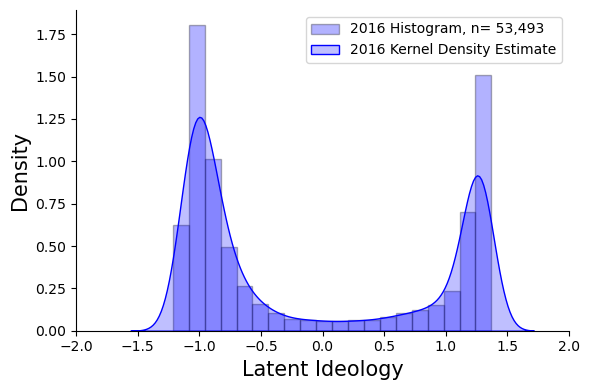

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

# Set the number of bins for the histogram
num_bins = 20

# Create a figure for the plot
plt.figure(figsize=(6, 4))

# Plot the histogram for the 2016 latent ideology estimates
plt.hist(temp_2016['est'], bins=num_bins, edgecolor='black', density=True, alpha=0.3, color='blue', label='2016 Histogram, n= 53,493')

# Overlay the KDE plot on top of the histogram
sns.kdeplot(data=temp_2016['est'], label='2016 Kernel Density Estimate', fill=True, color='blue')

# Label the axes
plt.ylabel('Density', fontsize=15)
plt.xlabel('Latent Ideology', fontsize=15)

# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Set the x-axis limits
plt.xlim([-2, 2])

# Force y-axis to show numbers with 2 decimal places
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Adjust layout to prevent x-label cutoff
plt.tight_layout()

# Show the legend and the plot
plt.legend()
# Save the plot as a PDF file
plt.savefig('plots/2016_LI.pdf')

plt.show()


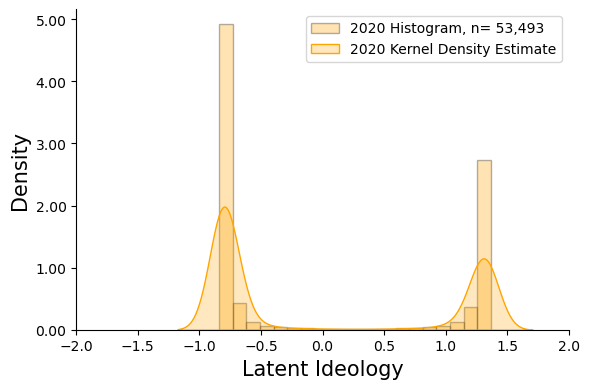

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

# Set the number of bins for the histogram
num_bins = 20

# Create a figure for the plot
plt.figure(figsize=(6, 4))

# Plot the histogram for the 2016 latent ideology estimates
plt.hist(temp_2020['est'], bins=num_bins, edgecolor='black', density=True, alpha=0.3, color='orange', label='2020 Histogram, n= 53,493')

# Overlay the KDE plot on top of the histogram
sns.kdeplot(data=temp_2020['est'], label='2020 Kernel Density Estimate', fill=True, color='orange')

# Label the axes
plt.ylabel('Density', fontsize=15)
plt.xlabel('Latent Ideology', fontsize=15)

# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Set the x-axis limits
plt.xlim([-2, 2])

# Force y-axis to show numbers with 2 decimal places
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Adjust layout to prevent x-label cutoff
plt.tight_layout()

# Show the legend and the plot
plt.legend()
# Save the plot as a PDF file
plt.savefig('plots/2020_LI.pdf')

plt.show()


In [10]:
# Group by ideology for both 2016 and 2020 data
left_group_2016 = temp_2016[temp_2016.est < -0.5][['account_id', '2016_prevalence']]
right_group_2016 = temp_2016[temp_2016.est > 0.5][['account_id', '2016_prevalence']]
left_group_2020 = temp_2020[temp_2020.est < -0.5][['account_id', '2020_prevalence']]
right_group_2020 = temp_2020[temp_2020.est > 0.5][['account_id', '2020_prevalence']]

# Merge data to handle changes in group size - only keep common users in both years
merged_l = pd.merge(left_group_2016, left_group_2020, on='account_id', how='inner')
merged_r = pd.merge(right_group_2016, right_group_2020, on='account_id', how='inner')

# Compare the changes using paired t-tests
t_stat_left, p_value_left = ttest_rel(merged_l['2020_prevalence'], merged_l['2016_prevalence'], alternative='greater')
t_stat_right, p_value_right = ttest_rel(merged_r['2020_prevalence'], merged_r['2016_prevalence'], alternative='greater')

print('Number of users belonging to the left ideology:', len(merged_l))
# Output results for the left group
if p_value_left < 0.05:
    print(f'Paired t-test results for left 2016 vs left 2020: t-statistic = {t_stat_left}, p-value = {p_value_left}')
    print("The differences are statistically significant.\n")
else:
    print(f'Paired t-test results for left 2016 vs left 2020: t-statistic = {t_stat_left}, p-value = {p_value_left}')
    print("The differences are not statistically significant.\n")

print('Number of users belonging to the right ideology:', len(merged_r))
# Output results for the right group
if p_value_right < 0.05:
    print(f'Paired t-test results for right 2016 vs right 2020: t-statistic = {t_stat_right}, p-value = {p_value_right}')
    print("The differences are statistically significant.\n")
else:
    print(f'Paired t-test results for right 2016 vs right 2020: t-statistic = {t_stat_right}, p-value = {p_value_right}')
    print("The differences are not statistically significant.\n")


Number of users belonging to the left ideology: 29048
Paired t-test results for left 2016 vs left 2020: t-statistic = 113.40280322680447, p-value = 0.0
The differences are statistically significant.

Number of users belonging to the right ideology: 18631
Paired t-test results for right 2016 vs right 2020: t-statistic = 93.46524408985692, p-value = 0.0
The differences are statistically significant.



In [11]:
# Find users who switched from left to right and right to left
merged_lr = pd.merge(left_group_2016, right_group_2020, on='account_id', how='inner').dropna()
merged_rl = pd.merge(right_group_2016, left_group_2020, on='account_id', how='inner').dropna()

# Compare the changes using paired t-tests
t_stat_lr, p_value_lr = ttest_rel(merged_lr['2020_prevalence'], 
                                  merged_lr['2016_prevalence'], alternative='greater')

t_stat_rl, p_value_rl = ttest_rel(merged_rl['2020_prevalence'],
                                  merged_rl['2016_prevalence'], alternative='greater')

# Print the number of users who switched ideologies
print(f'Number of users who switched from left to right: {len(merged_lr)}')
# Output the results for left-to-right switchers
if p_value_lr < 0.05:
    print(f'Paired t-test results for left-to-right switchers (2016 vs 2020): t-statistic = {t_stat_lr}, p-value = {p_value_lr}')
    print("The differences are statistically significant.\n")
else:
    print(f'Paired t-test results for left-to-right switchers (2016 vs 2020): t-statistic = {t_stat_lr}, p-value = {p_value_lr}')
    print("The differences are not statistically significant.\n")

print(f'Number of users who switched from right to left: {len(merged_rl)}')
# Output the results for right-to-left switchers
if p_value_rl < 0.05:
    print(f'Paired t-test results for right-to-left switchers (2016 vs 2020): t-statistic = {t_stat_rl}, p-value = {p_value_rl}')
    print("The differences are statistically significant.\n")
else:
    print(f'Paired t-test results for right-to-left switchers (2016 vs 2020): t-statistic = {t_stat_rl}, p-value = {p_value_rl}')
    print("The differences are not statistically significant.\n")

Number of users who switched from left to right: 210
Paired t-test results for left-to-right switchers (2016 vs 2020): t-statistic = 7.826977465013509, p-value = 1.2293665211602544e-13
The differences are statistically significant.

Number of users who switched from right to left: 878
Paired t-test results for right-to-left switchers (2016 vs 2020): t-statistic = 22.935959775639464, p-value = 7.146837831264529e-92
The differences are statistically significant.



In [12]:
# Calculate the percentage change in CDS prevalence from 2016 to 2020 for left- and right-leaning users
diff_per_l = (merged_l['2020_prevalence'] - merged_l['2016_prevalence']) / merged_l['2016_prevalence']
diff_per_r = (merged_r['2020_prevalence'] - merged_r['2016_prevalence']) / merged_r['2016_prevalence']

# Print the mean relative change for both groups
print('Relative change in CDS prevalence for left-leaning:', round(diff_per_l.mean(),2),'%')
print('Relative change in CDS prevalence for right-leaning:', round(diff_per_r.mean(),2),'%')


# Perform an independent t-test to compare the percentage changes between the two groups
t_stat_lr, p_value_lr = ttest_ind(diff_per_r.dropna(), diff_per_l.dropna(), alternative='greater')

print('\n')
# Output the results
if p_value_lr < 0.05:
    print(f'Independent t-test results for diff_per_l vs diff_per_r: t-statistic = {t_stat_lr}, p-value = {p_value_lr}')
    print("The differences are statistically significant.\n")
else:
    print(f'Independent t-test results for diff_per_l vs diff_per_r: t-statistic = {t_stat_lr}, p-value = {p_value_lr}')
    print("The differences are not statistically significant.\n")



Relative change in CDS prevalence for left-leaning: 0.72 %
Relative change in CDS prevalence for right-leaning: 0.8 %


Independent t-test results for diff_per_l vs diff_per_r: t-statistic = 6.742167002856453, p-value = 7.89074342981971e-12
The differences are statistically significant.

